In [28]:
import numpy as np
import torch
from utils import LinCKA2
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group
import sys
from torch import nn
import cca_core

In [29]:
# Code adapted from Grounding ...
# Added imports
import sklearn.metrics.pairwise as pw


## CCA
def cca_decomp(A, B):
    """Computes CCA vectors, correlations, and transformed matrices
    requires a < n and b < n
    Args:
        A: np.array of size a x n where a is the number of neurons and n is the dataset size
        B: np.array of size b x n where b is the number of neurons and n is the dataset size
    Returns:
        u: left singular vectors for the inner SVD problem
        s: canonical correlation coefficients
        vh: right singular vectors for the inner SVD problem
        transformed_a: canonical vectors for matrix A, a x n array
        transformed_b: canonical vectors for matrix B, b x n array
    """
    assert A.shape[0] < A.shape[1]
    assert B.shape[0] < B.shape[1]

    evals_a, evecs_a = np.linalg.eigh(A @ A.T)
    evals_a = (evals_a + np.abs(evals_a)) / 2
    inv_a = np.array([1 / np.sqrt(x) if x > 0 else 0 for x in evals_a])

    evals_b, evecs_b = np.linalg.eigh(B @ B.T)
    evals_b = (evals_b + np.abs(evals_b)) / 2
    inv_b = np.array([1 / np.sqrt(x) if x > 0 else 0 for x in evals_b])

    cov_ab = A @ B.T

    temp = (
        (evecs_a @ np.diag(inv_a) @ evecs_a.T)
        @ cov_ab
        @ (evecs_b @ np.diag(inv_b) @ evecs_b.T)
    )

    try:
        u, s, vh = np.linalg.svd(temp)
    except:
        u, s, vh = np.linalg.svd(temp * 100)
        s = s / 100

    transformed_a = (u.T @ (evecs_a @ np.diag(inv_a) @ evecs_a.T) @ A).T
    transformed_b = (vh @ (evecs_b @ np.diag(inv_b) @ evecs_b.T) @ B).T
    return u, s, vh, transformed_a, transformed_b


def mean_sq_cca_corr(rho):
    """Compute mean squared CCA correlation
    :param rho: canonical correlation coefficients returned by cca_decomp(A,B)
    """
    # len(rho) is min(A.shape[0], B.shape[0])
    return np.sum(rho * rho) / len(rho) # THESE ARE NOT WRITTEN AS DISTANCES... WTF?


def mean_cca_corr(rho):
    """Compute mean CCA correlation
    :param rho: canonical correlation coefficients returned by cca_decomp(A,B)
    """
    # len(rho) is min(A.shape[0], B.shape[0])
    return np.sum(rho) / len(rho) # THESE ARE NOT WRITTEN AS DISTANCES... WTF?


def pwcca_dist(A, rho, transformed_a):
    """Computes projection weighted CCA distance between A and B given the correlation
    coefficients rho and the transformed matrices after running CCA
    :param A: np.array of size a x n where a is the number of neurons and n is the dataset size
    :param B: np.array of size b x n where b is the number of neurons and n is the dataset size
    :param rho: canonical correlation coefficients returned by cca_decomp(A,B)
    :param transformed_a: canonical vectors for A returned by cca_decomp(A,B)
    :param transformed_b: canonical vectors for B returned by cca_decomp(A,B)
    :return: PWCCA distance
    """
    in_prod = transformed_a.T @ A.T
    weights = np.sum(np.abs(in_prod), axis=1)
    weights = weights / np.sum(weights)
    dim = min(len(weights), len(rho))
#     return 1 - np.dot(weights[:dim], rho[:dim]) # THIS IS WRITTEN AS A DISTANCE
    return np.dot(weights[:dim], rho[:dim])

## Procrustes
def procrustes(A, B):
    """
    Computes Procrustes distance bewteen representations A and B
    """
    A_sq_frob = np.sum(A ** 2)
    B_sq_frob = np.sum(B ** 2)
    nuc = np.linalg.norm(A @ B.T, ord="nuc")  # O(p * p * n)
    return 1-(A_sq_frob + B_sq_frob - 2 * nuc)

# 2 Gaussians (or 2 cubes) translation exp

In [41]:
cuda = torch.device('cuda')

def get_cka_test(mean1 = 0,
                 mean2 = 0,
                 var1 = 1,
                 var2 = 1,
                 num_dims = 100,
                 num_pts = 1000,
                 seed = 0,
                 c = 1000,
                 verbose = False,
                 distribution = 'gaussian',
                 rep_sim_mes = 'cka'):
    np.random.seed(seed)
    
    d = np.random.normal(0,1,[num_dims])
    d /= np.linalg.norm(d)
    
    if distribution == 'gaussian':
        X = np.concatenate( [np.random.normal(mean1, var1, [num_pts, num_dims]), np.random.normal(mean2, var2, [num_pts, num_dims])], axis = 0)
        Y = torch.Tensor(X + np.concatenate([np.zeros([num_pts, num_dims]), c*np.matmul(np.ones([num_pts,1]), d.reshape([1,num_dims]))], axis = 0)).to(cuda)
    elif distribution == 'uniform':
        # in this case var = side and mean = center
        X = np.concatenate([var1*(np.random.rand(num_pts, num_dims)-var1*0.5*np.ones([num_pts,num_dims]))+mean1*np.concatenate([np.ones([num_pts,1]),np.zeros([num_pts,num_dims-1])], axis=1), var2*(np.random.rand(num_pts, num_dims)-var2*0.5*np.ones([num_pts,num_dims]))+mean2*np.concatenate([np.ones([num_pts,1]),np.zeros([num_pts,num_dims-1])], axis=1)], axis = 0)
        Y = torch.Tensor(X + np.concatenate([np.zeros([num_pts, num_dims]), c*np.matmul(np.ones([num_pts,1]), d.reshape([1,num_dims]))], axis = 0)).to(cuda)
    
    X = torch.Tensor(X).to(cuda)
    
    if rep_sim_mes == 'cka':
        CKA = LinCKA2()
        if verbose:
            return CKA(X,Y).item(), torch.where(X==Y)
        else:
            return CKA(X,Y).item()
    else:
        X = np.array(X.to('cpu'))
        Y = np.array(Y.to('cpu'))
        
        X = X.T
        Y = Y.T
    
        # center each row
        rep1 = X - X.mean(axis=1, keepdims=True)
        rep2 = Y - Y.mean(axis=1, keepdims=True)

#         # normalize each representation
#         rep1 = rep1 / np.linalg.norm(rep1)
#         rep2 = rep2 / np.linalg.norm(rep2)
        
        if rep_sim_mes == 'pwcca':
            cca_u, cca_rho, cca_vh, transformed_rep1, transformed_rep2 = cca_decomp(rep1, rep2)
            return pwcca_dist(rep1, cca_rho, transformed_rep1)
        elif rep_sim_mes == 'mean_sq_cca_corr':
            cca_u, cca_rho, cca_vh, transformed_rep1, transformed_rep2 = cca_decomp(rep1, rep2)
            return mean_sq_cca_corr(cca_rho)
        elif rep_sim_mes == "mean_cca_corr":
            cca_u, cca_rho, cca_vh, transformed_rep1, transformed_rep2 = cca_decomp(rep1, rep2)
            return mean_cca_corr(cca_rho)
        elif rep_sim_mes == "svcca":
            # Perform SVD
            U1, s1, V1 = np.linalg.svd(rep1, full_matrices=False)
            lambda1 = (s1**2)/(rep1.shape[1]-1)
            lambda1_cumsum = np.cumsum(lambda1)
            dim1 = np.where(lambda1_cumsum > 0.99*np.sum(lambda1))[0][0]
            U2, s2, V2 = np.linalg.svd(rep2, full_matrices=False)
            lambda2 = (s2**2)/(rep2.shape[1]-1)
            lambda2_cumsum = np.cumsum(lambda2)
            dim2 = np.where(lambda2_cumsum > 0.99*np.sum(lambda2))[0][0]

            svacts1 = np.dot(s1[:dim1]*np.eye(dim1), V1[:dim1])
            # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
            svacts2 = np.dot(s2[:dim2]*np.eye(dim2), V2[:dim2])
            # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)
            
            cca_u, cca_rho, cca_vh, transformed_rep1, transformed_rep2 = cca_decomp(svacts1, svacts2)
            return mean_cca_corr(cca_rho)
        elif rep_sim_mes == "procrustes":
            # normalize each representation
            rep1 = rep1 / np.linalg.norm(rep1)
            rep2 = rep2 / np.linalg.norm(rep2)
            return procrustes(rep1, rep2)
        elif rep_sim_mes == 'mean_cca_corr_off':
            return np.mean(cca_core.get_cca_similarity(rep1, rep2, verbose=True)['cca_coef1'])

# Translations (multiple seeds)

In [44]:
num_pts = 10000
num_dims = 1000
num_seeds = 5
c_list = [0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
rep_sim_measures = ['mean_cca_corr', 'svcca', 'pwcca', 'procrustes']
# rep_sim_measures = [ 'svcca']
# rep_sim_measures = ['mean_cca_corr_off', 'mean_cca_corr']#, 'pwcca', 'procrustes']

data = np.zeros([len(rep_sim_measures), num_seeds, len(c_list)])
for mes_idx, rep_sim_mes in enumerate(rep_sim_measures):
    print(rep_sim_mes)
    for seed in range(num_seeds):
        print(f'seed {seed}')
        for i, c in enumerate(c_list):
            data[mes_idx, seed, i] = get_cka_test(mean2=1.1, num_dims = num_dims, num_pts = num_pts, c = c, seed = seed, distribution = 'uniform', verbose = True, rep_sim_mes = rep_sim_mes)
            
np.save('two_cubes_exp_other_measures_means_0_1.1_{}seeds_v2.npy'.format(num_seeds), data)

mean_cca_corr
seed 0
seed 1
seed 2
seed 3
seed 4
svcca
seed 0
seed 1
seed 2
seed 3
seed 4
pwcca
seed 0
seed 1
seed 2
seed 3
seed 4
procrustes
seed 0
seed 1
seed 2
seed 3
seed 4


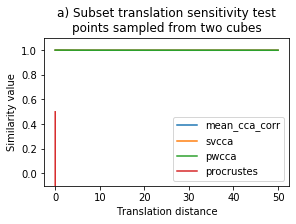

In [45]:
# mean_cca_corr_means = np.mean(data[0,:,:], axis = 0)
# mean_cca_corr_stds = np.std(data[0,:,:], axis = 0)

# mean_sq_cca_corr_means = np.mean(data[1,:,:], axis = 0)
# mean_sq_cca_corr_stds = np.std(data[1,:,:], axis = 0)

# pwcca_means = np.mean(data[2,:,:], axis = 0)
# pwcca_stds = np.std(data[2,:,:], axis = 0)

# procrustes_means = np.mean(data[3,:,:], axis = 0)
# procrustes_stds = np.std(data[3,:,:], axis = 0)

# from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1, figsize=(4,3), constrained_layout=True)

# # gauss translation
# ax.plot(c_list, mean_cca_corr_means, label = 'Mean CCA corrs')
# # ax.fill_between(c_list, mean_cca_corr_means-10*mean_cca_corr_stds, mean_cca_corr_means+10*mean_cca_corr_stds, alpha = 0.5)

# # ax.plot(c_list, mean_sq_cca_corr_means, label = 'Mean sq CCA corrs')
# # ax.fill_between(c_list, mean_sq_cca_corr_means-10*mean_sq_cca_corr_stds, mean_sq_cca_corr_means+10*mean_sq_cca_corr_stds, alpha = 0.5)

# ax.plot(c_list, pwcca_means, label = 'PWCCA')
# # ax.fill_between(c_list, pwcca_means-10*pwcca_stds, pwcca_means+10*pwcca_stds, alpha = 0.5)

# ax.plot(c_list, procrustes_means, label = 'Procrustes')
# # ax.fill_between(c_list, procrustes_means-10*procrustes_stds, procrustes_means+10*procrustes_stds, alpha = 0.5)

for idx, rep_sim_mes in enumerate(rep_sim_measures):
    means = np.mean(data[idx, :, :], axis = 0)
    stds = np.std(data[idx, :, :], axis = 0)
    ax.plot(c_list, means, label = rep_sim_mes)
    ax.fill_between(c_list, means-stds, means-stds, alpha = 0.5)

plt.axis([None, None, -0.1,1.1 ])
ax.set_xlabel('Translation distance')
ax.set_ylabel('Similarity value')
ax.set_title('a) Subset translation sensitivity test\npoints sampled from two cubes')
ax.legend()

# Invertible linear transformations (with cubes)

In [2]:
def inv_lin_cka_cubes(mean1 = 0,
                var1 = 1,
                mean2 = 0,
                var2 = 1,
                transform_mean = 0,
                transform_var = 1,
                num_dims = 200,
                num_pts = 10000,
                seed = 0,
                distribution = 'gaussian'):
    
    np.random.seed(seed)
    rotation_matrix = np.random.normal(transform_mean, transform_var,[num_dims, num_dims])
    while np.linalg.cond(rotation_matrix) >= 1/sys.float_info.epsilon:
        rotation_matrix = np.random.normal(transform_mean, transform_var,[num_dims, num_dims])

    cuda = torch.device('cuda')
    rotation_matrix = torch.Tensor(rotation_matrix).to(cuda)
    
    if distribution == 'gaussian':
        X = np.random.normal(mean1, var1, [int(num_pts*2), num_dims])
    elif distribution == 'uniform':
        # in this case var = side and mean = center
        X = np.concatenate([var1*(np.random.rand(num_pts, num_dims)-var1*0.5*np.ones([num_pts,num_dims]))+mean1*np.concatenate([np.ones([num_pts,1]),np.zeros([num_pts,num_dims-1])], axis=1), var2*(np.random.rand(num_pts, num_dims)-var2*0.5*np.ones([num_pts,num_dims]))+mean2*np.concatenate([np.ones([num_pts,1]),np.zeros([num_pts,num_dims-1])], axis=1)], axis = 0)

    X = torch.Tensor(X).to(cuda)
    Y = torch.mm(X,rotation_matrix)

    CKA = LinCKA2()
    return CKA(X,Y).item()

In [3]:
num_pts = 10000#, 10000 and 20000 points makes it crash have other things running as well...
num_dims = 500
num_seeds = 10
mu_list = [1, 5, 10, 25, 50, 100, 500, 1000, 5000, 1e4, 1e5]
sigma_list = [1, 5, 10, 25, 50, 100, 500, 1000, 5000, 1e4, 1e5]


data = np.zeros([num_seeds, len(mu_list), len(sigma_list)])
for seed in range(num_seeds):
    print(f'seed {seed}')
    for i1, mu in enumerate(mu_list):
        for i2, sigma in enumerate(sigma_list):
            data[seed, i1, i2] = inv_lin_cka_cubes(mean1=0, mean2=1.1,num_dims = num_dims, num_pts = num_pts, transform_mean=mu, transform_var=sigma, seed = seed, distribution = 'uniform')
            
np.save('inv_lin_cka_fig_data_lincka2_10k_cubes_means0_1.1.npy', data)

seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9
